# A2I Setup 
In order to integrate the human reviewer into our model's lifecycle we will leverage the SageMaker Augmented AI capability. 

- We will first define the workforce to use (ourselves) and create the "work team". We will do this through the AWS console UI (but we could have done that with code as well)
- Then we will create the specific template that we want to be using for this particular use-case.




## Creating the work team

1. Navigate to the SageMaker Console > Ground Truth > Labelling Workforce

![2-console-to-GT.png](images/2-console-to-GT.png)

2. Click to create the workforce, type the necessary information as displayed in the image below and click create. (Please use an email to which you have access now, since we will need you to verify the account in the next steps)

![2-create-workforce.png](images/2-create-workforce.png)

3. Immediately after, you should be seing this success message
![2-workteam-succesfully-created.png](images/2-workteam-succesfully-created.png)

4. Check your email for an email from AWS. Please check your SPAM folder as well. It should look like the below. 
![2-email-received.png](images/2-email-received.png)

5. Click on the link provided and verify your labeller account. You should now be seeing the following portal. Keep this tab open, we will need it in a few minutes
![2-labeller-view.png](images/2-labeller-view.png)

Congratulations, half of this step is done!
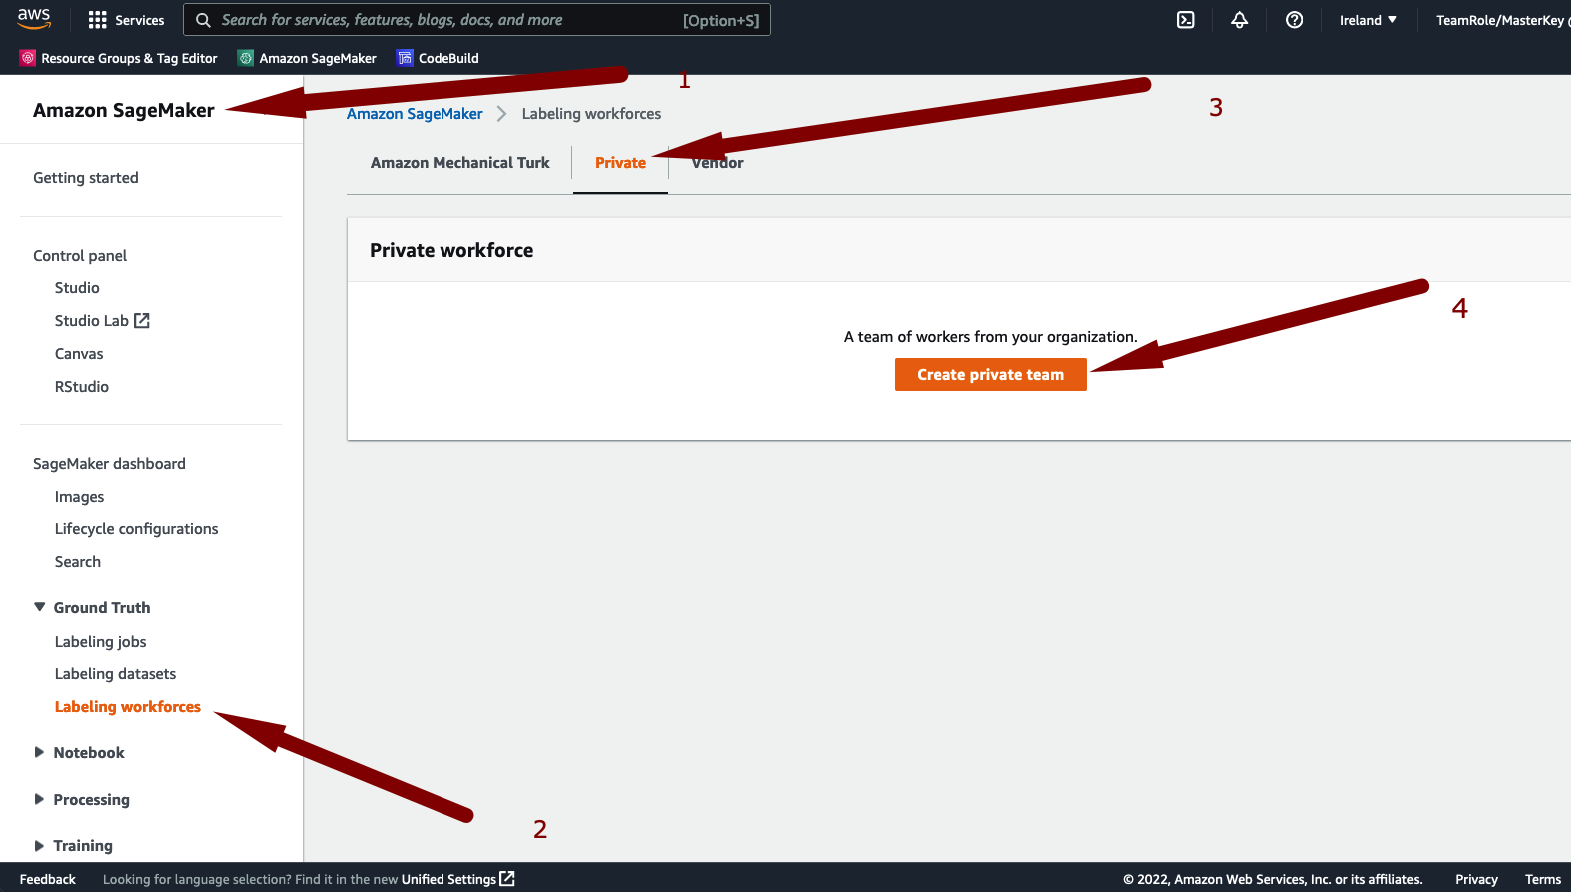
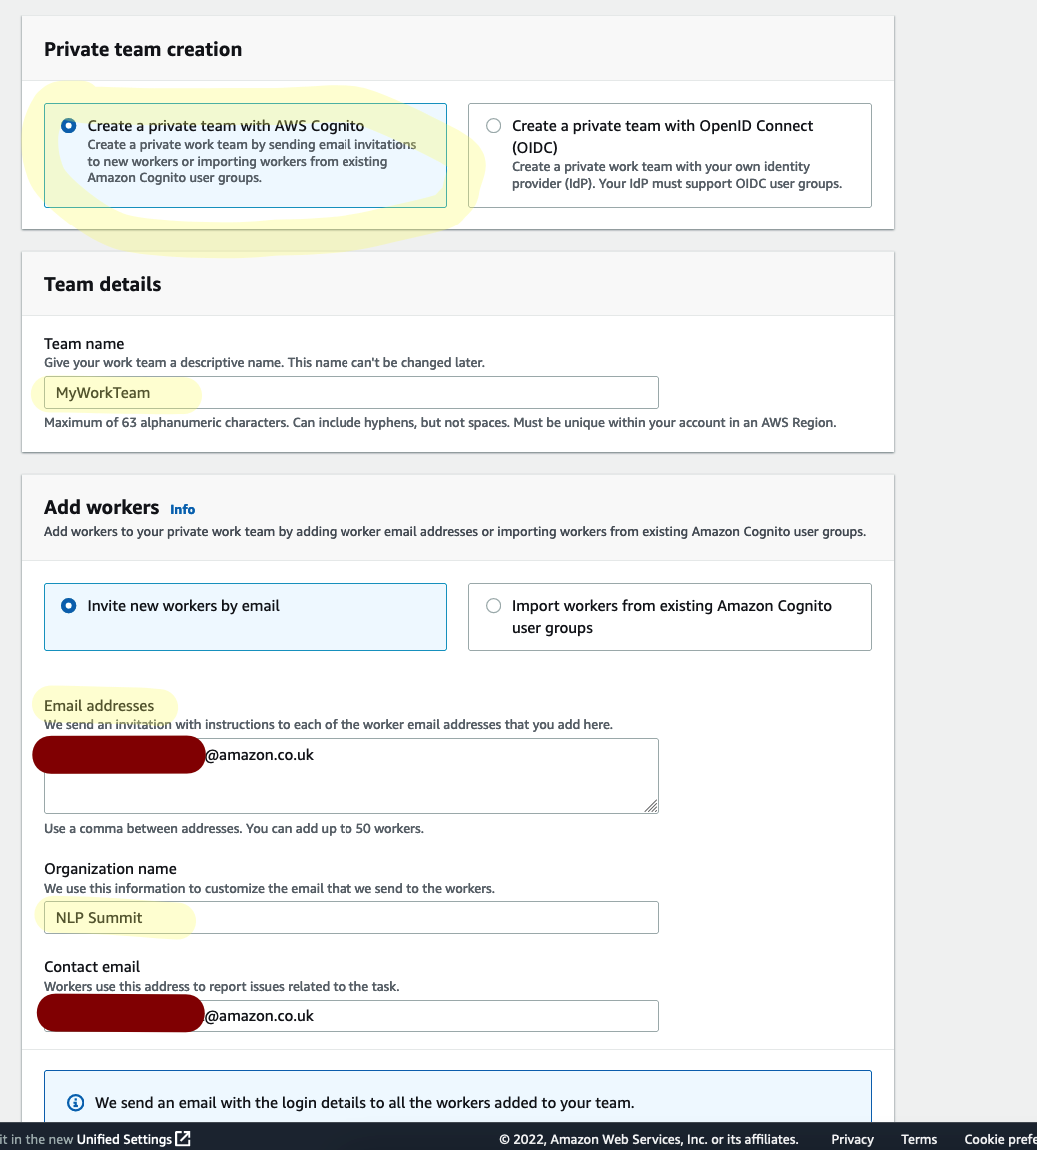
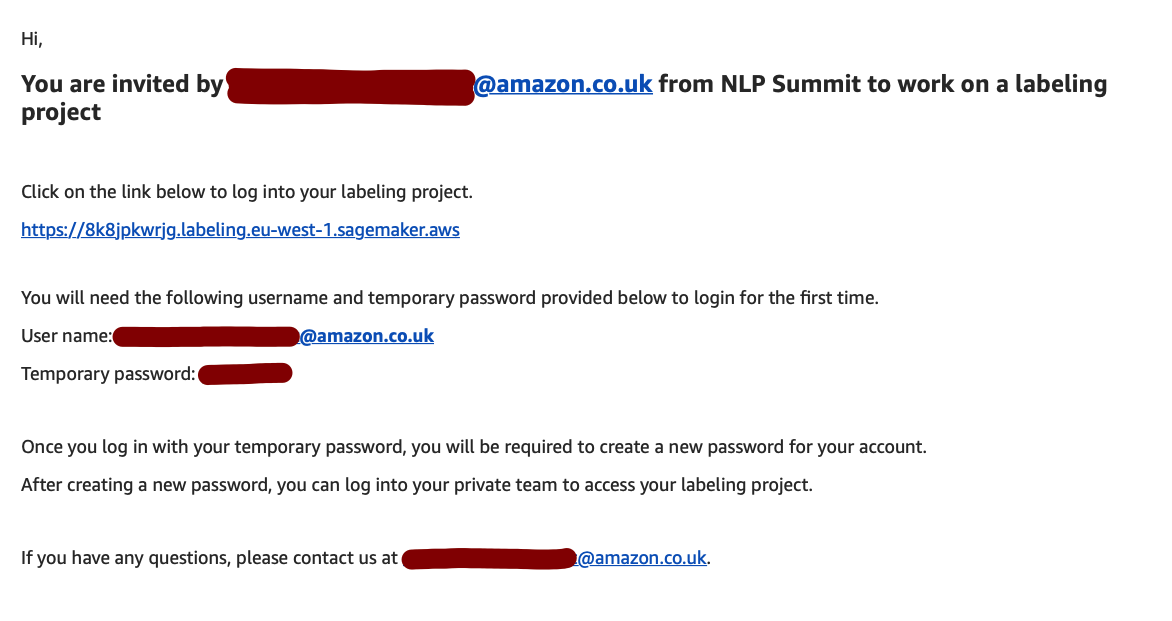
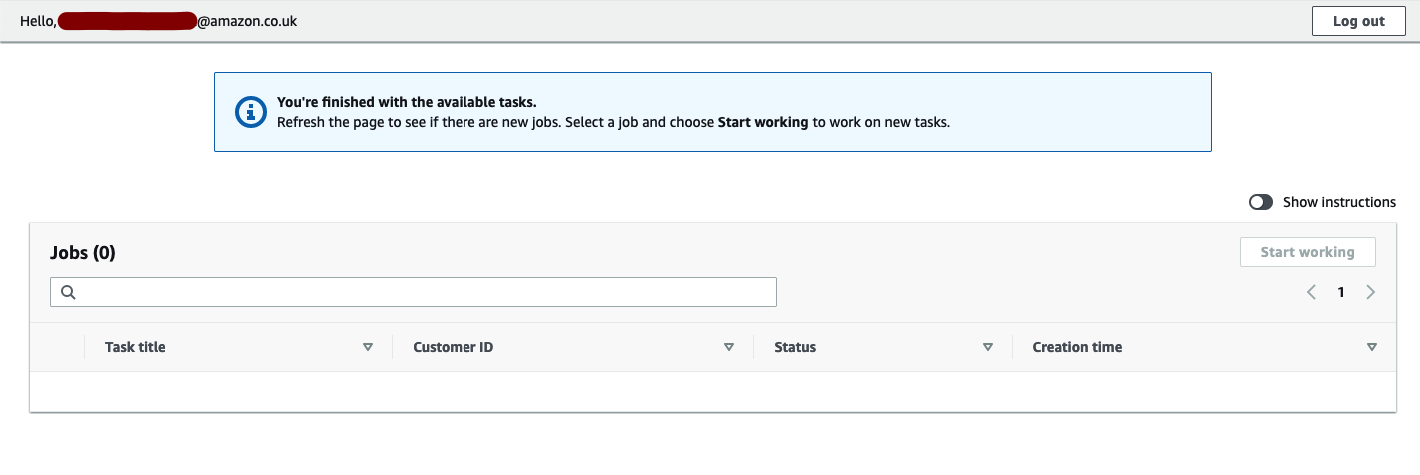
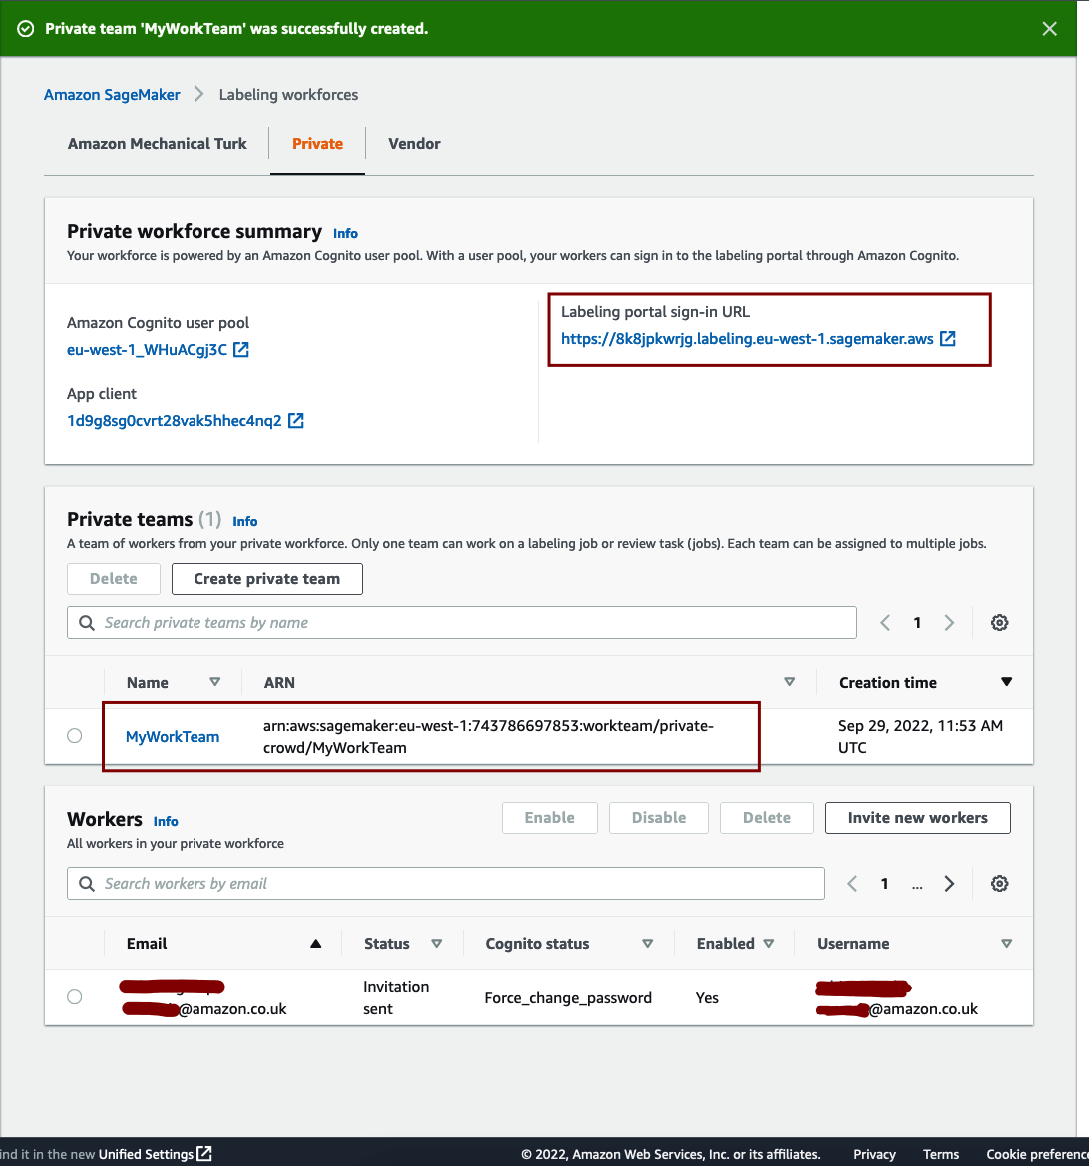

## Creating the template

We need to set up the following data:

REGION - Region to call A2I.

BUCKET_NAME - A S3 bucket accessible by the given role
    Used to store the input files and output results
    Must be within the same region A2I is called from
    
WORKTEAM_ARN - To create your Private Workteam, visit the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-private.html After you have created your workteam, replace \<YOUR-WORKTEAM-ARN> below

ROLE - The IAM role used as part of StartHumanLoop. By default, this notebook will use the execution role. You can learn more about IAM Policies here https://docs.aws.amazon.com/IAM/latest/UserGuide/access_policies.html



In [ ]:
import botocore
import sagemaker
import boto3
import io
import json
import uuid
import time

In [ ]:
# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker')
# A2I Runtime client
a2i_runtime_client = boto3.client('sagemaker-a2i-runtime')

sm_runtime_client = boto3.client('sagemaker-runtime')

In [ ]:
WORKTEAM_ARN = "<<ENTER WORKTEAM ARN>>"
BUCKET = sagemaker.Session().default_bucket()
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
prefix = "custom-classify" + str(uuid.uuid1())

if WORKTEAM_ARN == "<<ENTER WORKTEAM ARN>>":
    WORKTEAM_ARN = sagemaker_client.list_workteams(SortOrder='Descending')["Workteams"][0]["WorkteamArn"]
    print("workteam was not provided, using the most recently created one")
    print(WORKTEAM_ARN)

# Setting up an Amazon A2I human loop

In this section, you set up a human review loop for low-confidence detection in Amazon A2I. It includes the following steps:

    Step 1. Create a Worker Task template.
    Step 2. Create a Human review workflow.


# Step 1. Create a Worker Task template

It is 2 step process:
    
    1. Select the UI template you want to use For over 70 pre built UIs, check: https://github.com/aws-samples/amazon-a2i-sample-task-uis
    
    2. Create Task template using create_human_task_ui API or you can do the same thing using the AWS Console.
    
    
In this workshop, we will use the following very simple template which is a slightly altered version of one of the available templates on the above GitHub link





In [ ]:
#1. Select the UI template for custom classification and modify the categories based on your labels
template = """<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <crowd-classifier-multi-select
      name="category"
      categories="['Positive','Negative', 'Not Clear']"
      header="Select the relevant sentiment"
    >
      <classification-target>
        {{ task.input.taskObject }}
      </classification-target>
      
      <full-instructions header="Text Categorization Instructions">
        <p><strong>Positive</strong> sentiment include: joy, excitement, delight</p>
        <p><strong>Negative</strong> sentiment include: anger, sarcasm, anxiety</p>
         <p><strong>Not Clear</strong> sentiment is not clear</p>
      </full-instructions>

      <short-instructions>
       Choose the sentiment that is expressed by the text. 
      </short-instructions>
    </crowd-classifier-multi-select>
</crowd-form>
"""

# Create a worker task template using boto3 API

response = client.create_human_task_ui(
    
    HumanTaskUiName='string',
    
    UiTemplate={
        'Content': 'string'
    },
    
    Tags=[
        {
            'Key': 'string',
            'Value': 'string'
        },
    ]
)

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_human_task_ui

In [ ]:
def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [ ]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = prefix + '-ui' 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

# Step 2. Create a Human review workflow
Use an Amazon Augmented AI (Amazon A2I) human review workflow, or flow definition, to specify the following: 
  

     The workforce that your tasks will be sent to.

     The instructions that your workforce will receive, which is called a worker task template.

     The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.

     Where your output data will be stored.
        
To create a flow definition using the SageMaker API, you use the CreateFlowDefinition operation

This demo is going to use the API, but you can optionally create this workflow definition in the console as well.

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.


In [ ]:


# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = prefix + '-fd-a2i' 

create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= role,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Read the instructions",
            "TaskTitle": "Classify the text"
        },
        OutputConfig={
            "S3OutputPath" : "s3://"+BUCKET+"/a2i-output"
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use


In [ ]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

In [ ]:


print(flowDefinitionArn)



## That was it! 
Now, given the above Flow Definition ARN we can immediately start human review tasks, on-demand 